# RandomForest trained on the whole Yandex dataset

In [1]:
import numpy as np
import scipy as sp
import time, datetime
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import precision_score, accuracy_score, make_scorer, precision_recall_curve, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

## 0.1 Set of functions for after-processing the data

In [155]:
def feat_to_input(ft_data, cl_names):
    """
    Stacking data with names from 'cl_names' into one feature array
    and labeling 'signal' with 1 and 'noise' with 0.
    -------
    Output:
    X - array of features
    y - array of corresponding target labels
    """
    X = pd.DataFrame(columns=ft_data[cl_names[0]].columns).values
    y = []
    for name in cl_names:
        idx = ft_data[name].index
        if name[0] == 'C' :
            targ = np.ones(len(idx))
        else: targ = np.zeros(len(idx))
        y = np.append(y,targ)
        X = np.vstack((X, ft_data[name].values))
    return X, y

In [154]:
def feat_to_input_split(ft_data, cl_names, test_size=0.1, shuffle=True):
    """
    Splitting data for train-test with or without shuffle.
    Stacking specified classes together considering target label (signal/background).
    -------
    Output: X_train, X_test, y_train, y_test
    """
    if shuffle:
        X, y = feat_to_input(ft_data, cl_names)
        X_tr, X_tt, y_tr, y_tt = train_test_split(X, y, test_size=test_size)
    else:
        y_tr = []
        y_tt = []
        X_tr = pd.DataFrame(columns=ft_data[cl_names[0]].columns).values
        X_tt = pd.DataFrame(columns=ft_data[cl_names[0]].columns).values
        for name in cl_names:
            if name[0]=='C': 
                y = np.ones(ft_data[name].shape[0])
            else: y = np.zeros(ft_data[name].shape[0])
            X = ft_data[name].values
            tmp_X_tr, tmp_X_tt, tmp_y_tr, tmp_y_tt = train_test_split(X, y, test_size=test_size, shuffle=False)
            X_tr = np.vstack((X_tr, tmp_X_tr))
            X_tt = np.vstack((X_tt, tmp_X_tt))
            y_tr = np.append(y_tr, tmp_y_tr)
            y_tt = np.append(y_tt, tmp_y_tt)
            
    return X_tr, X_tt, y_tr, y_tt

In [17]:
def drop_import_feat(ft_data, imp_ft, n_drop, shuffle_ft=False):
    """
    Dropping 'n_drop' most important features from 'imp_ft' importance list. 'shuffle' key imposes random droping.
    """
    imp_cols = (ft_data.columns)[np.argsort(imp_ft)].values
    if shuffle_ft: np.random.shuffle(imp_cols)
    return ft_data.drop(imp_cols[-n_drop:], axis=1)

In [19]:
class_names = ['C60keV','C80keV','C100keV','dust_fog','gamma']

## 1. Training on all samples

##### 1.1 Fitting the images and saving parameters into files
* performed in a separate notebook
* all images on 20 nodes ~5hours

##### 1.2 Loading files with input features

In [143]:
%%time
##### Loading previosly saved features

feat_all_stacked = {}
for name in class_names:
    feat_all_stacked[name] = pd.read_csv('C:/Artem/NEWS/params/all_yand_feat_'+name+'.csv', index_col=0)
    print(name,'   \t',feat_all_stacked[name].shape)

print('\n',feat_all_stacked['C100keV'].columns)

C60keV    	 (93421, 64)
C80keV    	 (61429, 64)
C100keV    	 (128006, 64)
dust_fog    	 (124863, 64)
gamma    	 (124464, 64)

 Index(['amplitude1', 'center_x1', 'center_y1', 'sig_xy1', 'area1', 'eps1',
       'maj_ax1', 'min_ax1', 'amplitude2', 'center_x2', 'center_y2', 'sig_xy2',
       'area2', 'eps2', 'maj_ax2', 'min_ax2', 'amplitude3', 'center_x3',
       'center_y3', 'sig_xy3', 'area3', 'eps3', 'maj_ax3', 'min_ax3',
       'amplitude4', 'center_x4', 'center_y4', 'sig_xy4', 'area4', 'eps4',
       'maj_ax4', 'min_ax4', 'amplitude5', 'center_x5', 'center_y5', 'sig_xy5',
       'area5', 'eps5', 'maj_ax5', 'min_ax5', 'amplitude6', 'center_x6',
       'center_y6', 'sig_xy6', 'area6', 'eps6', 'maj_ax6', 'min_ax6',
       'amplitude7', 'center_x7', 'center_y7', 'sig_xy7', 'area7', 'eps7',
       'maj_ax7', 'min_ax7', 'amplitude8', 'center_x8', 'center_y8', 'sig_xy8',
       'area8', 'eps8', 'maj_ax8', 'min_ax8'],
      dtype='object')
Wall time: 11.5 s


## 2. Training Random Forest

In [35]:
randcla = RandomForestClassifier(n_jobs=-1)

## 2.1 Training with shuffle in train-test-split

### 2.1.1 Training whole signal vs whole background

In [156]:
%%time
X_stacked, y_stacked = feat_to_input(feat_all_stacked, class_names)
X_stacked_train, X_stacked_test, y_stacked_train, y_stacked_test = train_test_split(X_stacked, y_stacked, test_size=0.1, shuffle=True)

Wall time: 3.9 s


In [157]:
%%time
randcla.set_params(n_estimators=100, n_jobs=-1)
randcla.fit(X_stacked_train, y_stacked_train)
print ('precision ', precision_score(y_stacked_test, randcla.predict(X_stacked_test)))

precision  0.999647141849
Wall time: 29 s


In [158]:
imp_feat_st_sh = randcla.feature_importances_
imp_feat_st_sh

array([ 0.02387771,  0.00614226,  0.01065201,  0.01975778,  0.01672862,
        0.01807353,  0.01609744,  0.01791526,  0.022563  ,  0.00622652,
        0.00781406,  0.02087398,  0.01776428,  0.01413323,  0.01582759,
        0.02216733,  0.02382322,  0.00625194,  0.00699949,  0.01595997,
        0.02014304,  0.01414869,  0.01673896,  0.02074304,  0.02587322,
        0.00610774,  0.00730802,  0.01485242,  0.0238061 ,  0.01567045,
        0.01708777,  0.01603277,  0.02611005,  0.005835  ,  0.00679181,
        0.01584532,  0.01663388,  0.01508504,  0.01588971,  0.01673262,
        0.02630762,  0.00571519,  0.00692163,  0.01822441,  0.01905364,
        0.01519365,  0.01535265,  0.0195839 ,  0.024141  ,  0.00580816,
        0.00681948,  0.01910508,  0.0181056 ,  0.01605533,  0.01509283,
        0.01980627,  0.02522405,  0.0056438 ,  0.00695404,  0.01756282,
        0.01668152,  0.01705025,  0.01513637,  0.01737583])

### 2.1.2 Comparing signal-background pair-wise

AUC_ROC scores
C60keV__dust_fog   	 0.9999997
C60keV__gamma   	 1.0
C80keV__dust_fog   	 0.9999998
C80keV__gamma   	 0.9999953
C100keV__dust_fog   	 0.9999999
C100keV__gamma   	 1.0
Wall time: 1min 2s


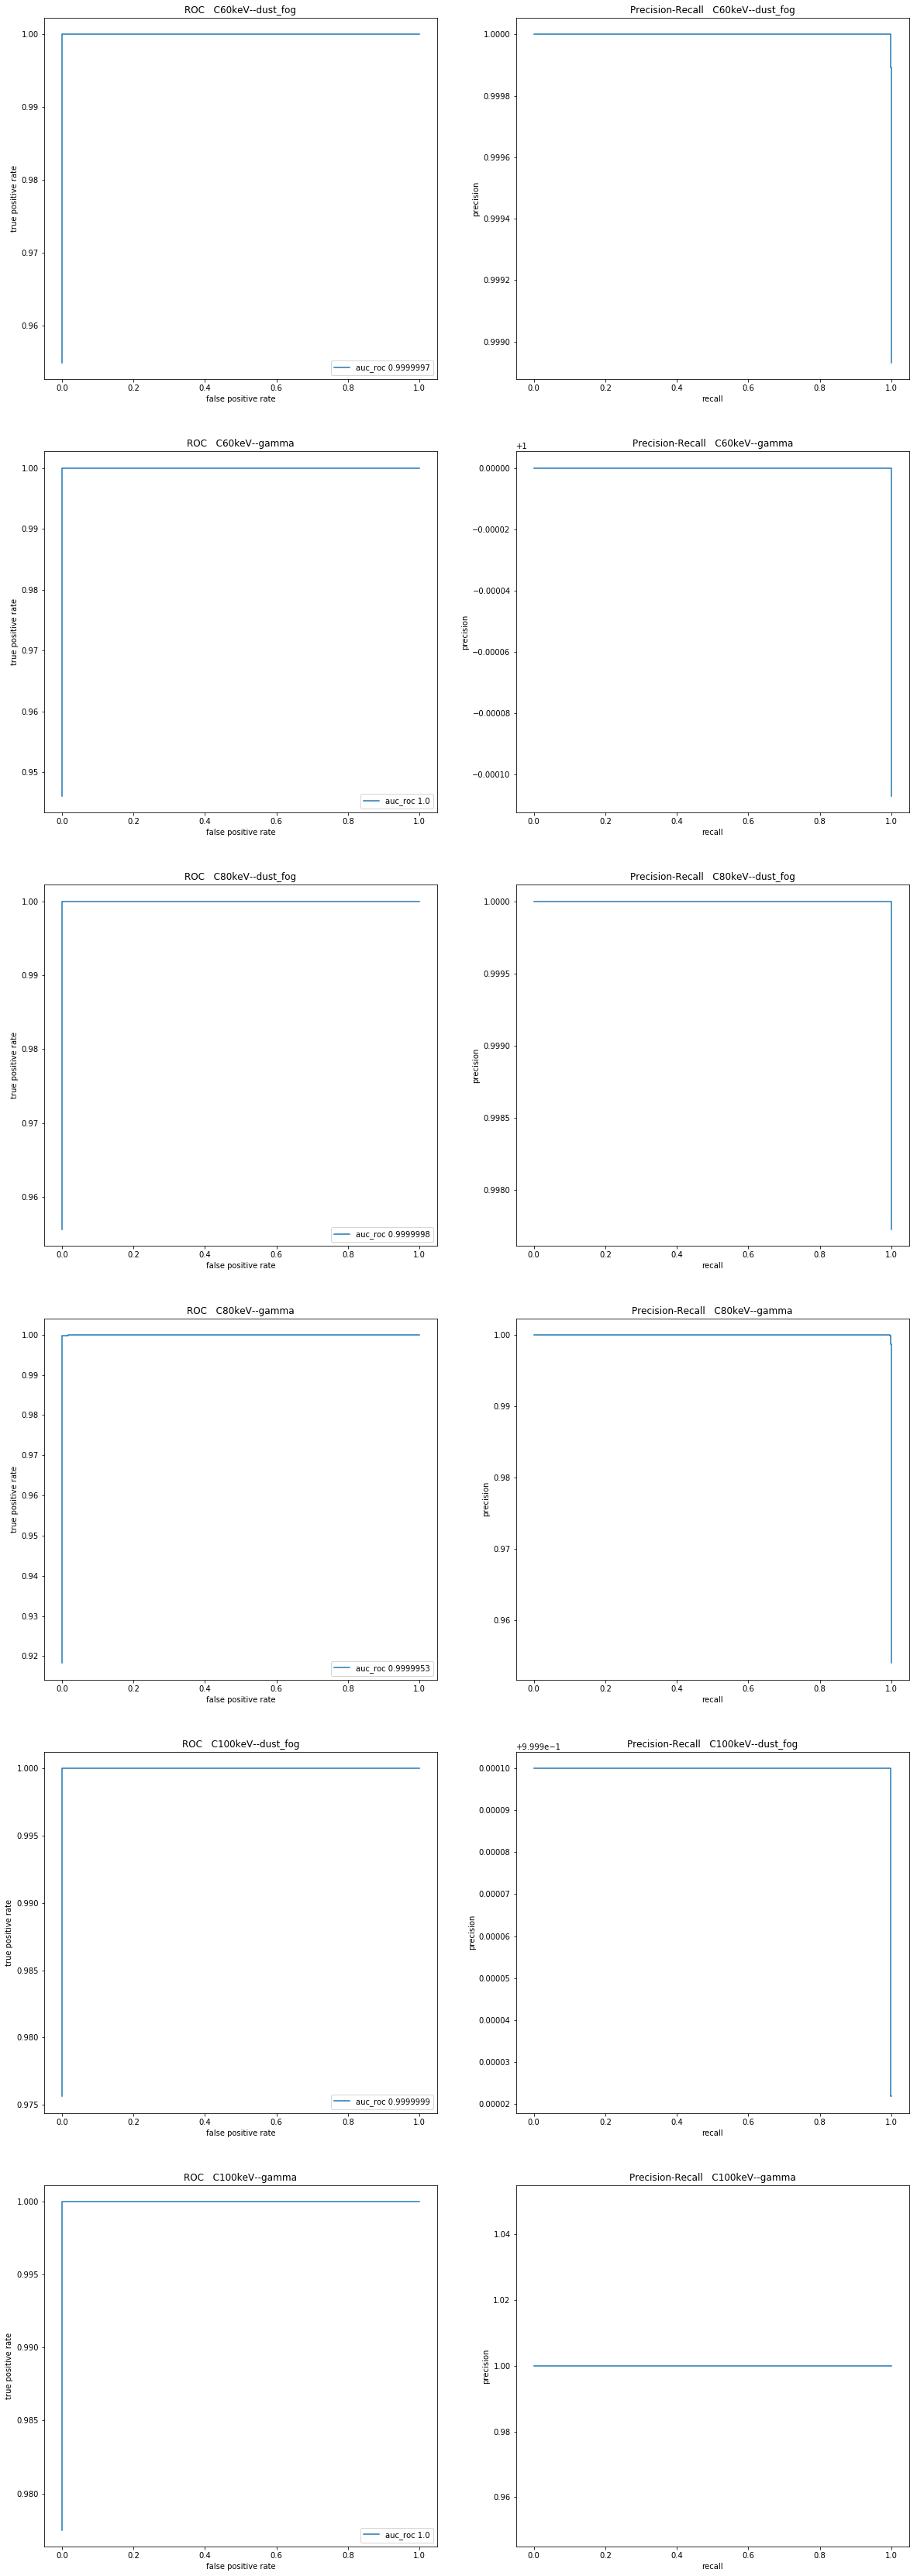

In [159]:
%%time
# Taking the best number of estimators from CV
#randcla.set_params(n_estimators = n_est[np.argmax(giant_rand_scores)])
randcla.set_params(n_estimators=100, n_jobs=-1)

f, axes = plt.subplots(6, 2, figsize=(20, 60))
axes = axes.ravel()
i=0
auc_rocs = {}
##### Creating the pairs of signal-noise for comparison
for name1 in class_names:
    for name2 in class_names:
        if (name1[0] == 'C') and (name2[0] != 'C'):
            X, y = feat_to_input(feat_all_stacked, [name1, name2])
            X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
            
            ##### Scoring the RF and building curves
            randcla.fit(X_train_raw, y_train)
            rand_pred = (randcla.predict_proba(X_test_raw))[:,1]
            
            auc_rocs[name1+'__'+name2] = roc_auc_score(y_test, rand_pred)
            fpr, tpr, thrsh = roc_curve(y_test, rand_pred)
            axes[i].step(fpr, tpr, label='auc_roc '+str(np.around(auc_rocs[name1+'__'+name2], decimals=7)))
            axes[i].set_title('ROC   '+name1+'--'+name2)
            axes[i].set_xlabel('false positive rate')
            axes[i].set_ylabel('true positive rate')
            axes[i].legend()
            i += 1
            prec, rec, thrsh = precision_recall_curve(y_test, rand_pred)
            axes[i].step(rec, prec)
            axes[i].set_title('Precision-Recall   '+name1+'--'+name2)
            axes[i].set_xlabel('recall')
            axes[i].set_ylabel('precision')
            i += 1
            
            
print ('AUC_ROC scores')
for (key,value) in auc_rocs.items():
    print (key,'  \t', np.around(value, decimals=7))

### 2.1.3 Dropping features

train_shape  (425746, 62)  test_shape  (106437, 62)  auc-roc:  0.999999619125
train_shape  (425746, 60)  test_shape  (106437, 60)  auc-roc:  0.999999371571
train_shape  (425746, 58)  test_shape  (106437, 58)  auc-roc:  0.999999531981
train_shape  (425746, 55)  test_shape  (106437, 55)  auc-roc:  0.999999452941
train_shape  (425746, 52)  test_shape  (106437, 52)  auc-roc:  0.999999402551
train_shape  (425746, 49)  test_shape  (106437, 49)  auc-roc:  0.999999644217
train_shape  (425746, 44)  test_shape  (106437, 44)  auc-roc:  0.999999282425
train_shape  (425746, 39)  test_shape  (106437, 39)  auc-roc:  0.999999235941
train_shape  (425746, 32)  test_shape  (106437, 32)  auc-roc:  0.999998785618
train_shape  (425746, 24)  test_shape  (106437, 24)  auc-roc:  0.999999422092

 Index(['center_x1', 'min_ax4', 'center_x6', 'amplitude7'], dtype='object')
train_shape  (425746, 4)  test_shape  (106437, 4)  auc-roc:  0.999994452688

 Index(['maj_ax1', 'area5'], dtype='object')
train_shape  (425746,

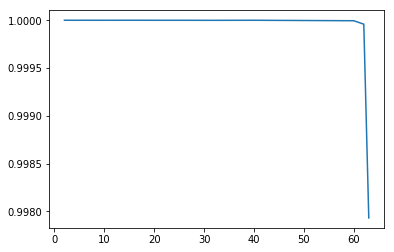

In [162]:
%%time
### SHUFFLE DATA
randcla.set_params(n_estimators = 100, n_jobs = -1, oob_score=False)
n_drops = [2, 4, 6, 9, 12, 15, 20, 25, 32, 40, 60, 62, 63]
feat_giant_st_dropped = {}
auc_rocs = []
for n in n_drops:
    shuffle_cols = np.copy((feat_all_stacked['C100keV'].columns)[np.argsort(imp_feat_st_sh)].values)
    np.random.shuffle(shuffle_cols)
    for name in class_names:
        feat_giant_st_dropped[name] = feat_all_stacked[name].drop(shuffle_cols[-n:], axis=1)
    
    X_train, X_test, y_train, y_test = feat_to_input_split(feat_giant_st_dropped, class_names, test_size=0.2, shuffle=True)
    
    randcla.fit(X_train, y_train)
    auc_rocs.append(roc_auc_score(y_test, (randcla.predict_proba(X_test))[:,1]))
    
    if feat_giant_st_dropped['C100keV'].shape[1]<10: print('\n',feat_giant_st_dropped['C100keV'].columns)
    print('train_shape ', X_train.shape, ' test_shape ', X_test.shape, ' auc-roc: ', auc_rocs[-1])
plt.plot(n_drops, auc_rocs)

# 51. TESTING AREA

##### <font color='red'> RANDOM CODE HAPPENS </font>

## 2.2 Training without shuffle in train-test-split

### 2.2.1 Training whole signal vs whole background

In [40]:
%%time
X_stacked_unsh_train, X_stacked_unsh_test, y_stacked_unsh_train, y_stacked_unsh_test = feat_to_input_split(feat_all_stacked, class_names, test_size=0.1, shuffle=False)

Wall time: 2.15 s


In [41]:
%%time
randcla.set_params(n_estimators=100, n_jobs=-1)
randcla.fit(X_stacked_unsh_train, y_stacked_unsh_train)
print ('precision ', precision_score(y_stacked_unsh_test, randcla.predict(X_stacked_unsh_test)))

precision  1.0
Wall time: 21.9 s


In [42]:
imp_feat_st_unsh = randcla.feature_importances_
imp_feat_st_unsh

array([ 0.02415421,  0.00623843,  0.01046387,  0.0198766 ,  0.01614888,
        0.01762199,  0.01437524,  0.01860644,  0.02351797,  0.00619298,
        0.00762015,  0.01991133,  0.01586831,  0.01424647,  0.01662316,
        0.02440667,  0.02300817,  0.00617249,  0.00694874,  0.01553853,
        0.02031093,  0.01423269,  0.01574067,  0.02148252,  0.02613408,
        0.00611329,  0.00705832,  0.01471475,  0.02094407,  0.01541262,
        0.01820249,  0.01871539,  0.02909806,  0.00581798,  0.0070554 ,
        0.01574221,  0.01766709,  0.01603004,  0.01474619,  0.01691661,
        0.02546206,  0.00584492,  0.0067173 ,  0.01941707,  0.01857984,
        0.0157567 ,  0.01483014,  0.01887443,  0.02377751,  0.00577602,
        0.00656791,  0.01878743,  0.01994885,  0.01603234,  0.01464075,
        0.01844422,  0.02501818,  0.00573794,  0.00699136,  0.01726441,
        0.01622787,  0.01626455,  0.01600679,  0.0173554 ])

### 2.2.2 Comparing signal-background pair-wise

AUC_ROC scores
C60keV__dust_fog   	 1.0
C60keV__gamma   	 1.0
C80keV__dust_fog   	 1.0
C80keV__gamma   	 1.0
C100keV__dust_fog   	 1.0
C100keV__gamma   	 1.0
Wall time: 51 s


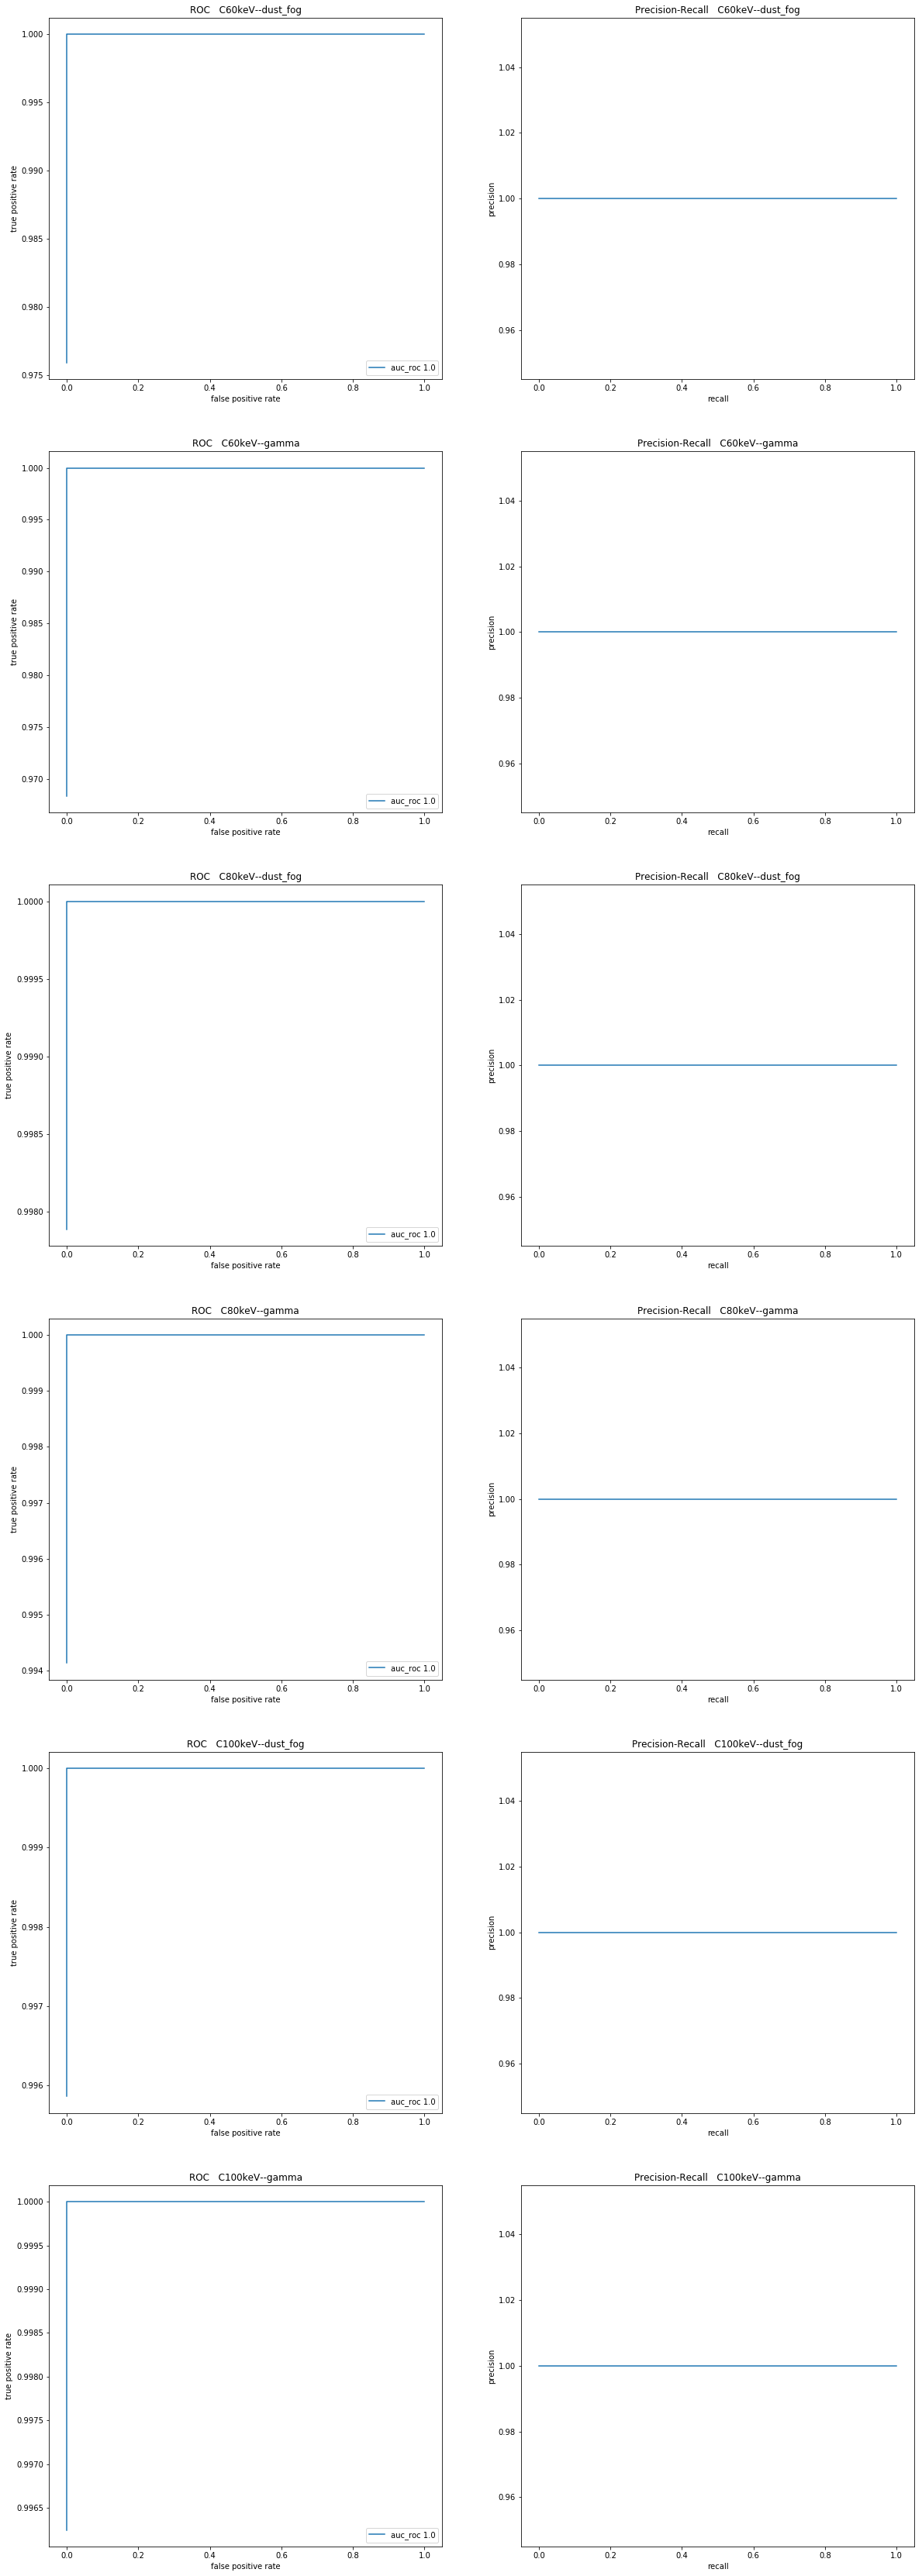

In [43]:
%%time
# Taking the best number of estimators from CV
#randcla.set_params(n_estimators = n_est[np.argmax(giant_rand_scores)])
randcla.set_params(n_estimators=100, n_jobs=-1)

f, axes = plt.subplots(6, 2, figsize=(20, 60))
axes = axes.ravel()
i=0
auc_rocs = {}
##### Creating the pairs of signal-noise for comparison
for name1 in class_names:
    for name2 in class_names:
        if (name1[0] == 'C') and (name2[0] != 'C'):
            X_train_raw, X_test_raw, y_train, y_test = feat_to_input_split(feat_all_stacked, [name1, name2], test_size=0.1, shuffle=False)
            ##### Scoring the RF and building curves
            randcla.fit(X_train_raw, y_train)
            rand_pred = (randcla.predict_proba(X_test_raw))[:,1]
            auc_rocs[name1+'__'+name2] = roc_auc_score(y_test, rand_pred)
            fpr, tpr, thrsh = roc_curve(y_test, rand_pred)
            axes[i].step(fpr, tpr, label='auc_roc '+str(np.around(auc_rocs[name1+'__'+name2], decimals=7)))
            axes[i].set_title('ROC   '+name1+'--'+name2)
            axes[i].set_xlabel('false positive rate')
            axes[i].set_ylabel('true positive rate')
            axes[i].legend()
            i += 1
            prec, rec, thrsh = precision_recall_curve(y_test, rand_pred)
            axes[i].step(rec, prec)
            axes[i].set_title('Precision-Recall   '+name1+'--'+name2)
            axes[i].set_xlabel('recall')
            axes[i].set_ylabel('precision')
            i += 1
            
            
print ('AUC_ROC scores')
for (key,value) in auc_rocs.items():
    print (key,'  \t', np.around(value, decimals=7))

### 2.2.3 Dropping random features.

train_shape  (399135, 62)  auc-roc:  1.0
train_shape  (399135, 60)  auc-roc:  1.0
train_shape  (399135, 58)  auc-roc:  1.0
train_shape  (399135, 55)  auc-roc:  1.0
train_shape  (399135, 52)  auc-roc:  1.0
train_shape  (399135, 49)  auc-roc:  1.0
train_shape  (399135, 44)  auc-roc:  1.0
train_shape  (399135, 39)  auc-roc:  1.0
train_shape  (399135, 32)  auc-roc:  1.0
train_shape  (399135, 24)  auc-roc:  1.0

 Index(['eps1', 'sig_xy4', 'min_ax7', 'amplitude8'], dtype='object')
train_shape  (399135, 4)  auc-roc:  1.0

 Index(['amplitude3', 'area3'], dtype='object')
train_shape  (399135, 2)  auc-roc:  1.0

 Index(['center_x6'], dtype='object')
train_shape  (399135, 1)  auc-roc:  0.999977472224
Wall time: 3min 28s


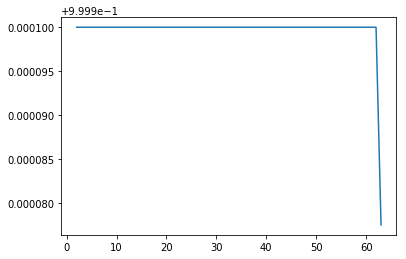

In [76]:
%%time
### NOT SHUFFLE DATA
randcla.set_params(n_estimators = 100, n_jobs = -1, oob_score=False)
n_drops = [2, 4, 6, 9, 12, 15, 20, 25, 32, 40, 60, 62, 63]
feat_giant_st_dropped = {}
auc_rocs = []
for n in n_drops:
    shuffle_cols = np.copy((feat_all_stacked['C100keV'].columns)[np.argsort(imp_feat_st_unsh)].values)
    np.random.shuffle(shuffle_cols)
    #print(shuffle_cols,'\n')
    for name in class_names:
        feat_giant_st_dropped[name] = feat_all_stacked[name].drop(shuffle_cols[-n:], axis=1)
    X_train, X_test, y_train, y_test = feat_to_input_split(feat_giant_st_dropped, class_names, test_size=0.25, shuffle=False)
    randcla.fit(X_train, y_train)
    auc_rocs.append(roc_auc_score(y_test, (randcla.predict_proba(X_test))[:,1]))
    if feat_giant_st_dropped['C100keV'].shape[1]<10: print('\n',feat_giant_st_dropped['C100keV'].columns)
    print('train_shape ', X_train.shape, ' auc-roc: ', auc_rocs[-1])
plt.plot(n_drops, auc_rocs)

## 7. Visualisation of training data

C:\Artem\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


Wall time: 1.75 s


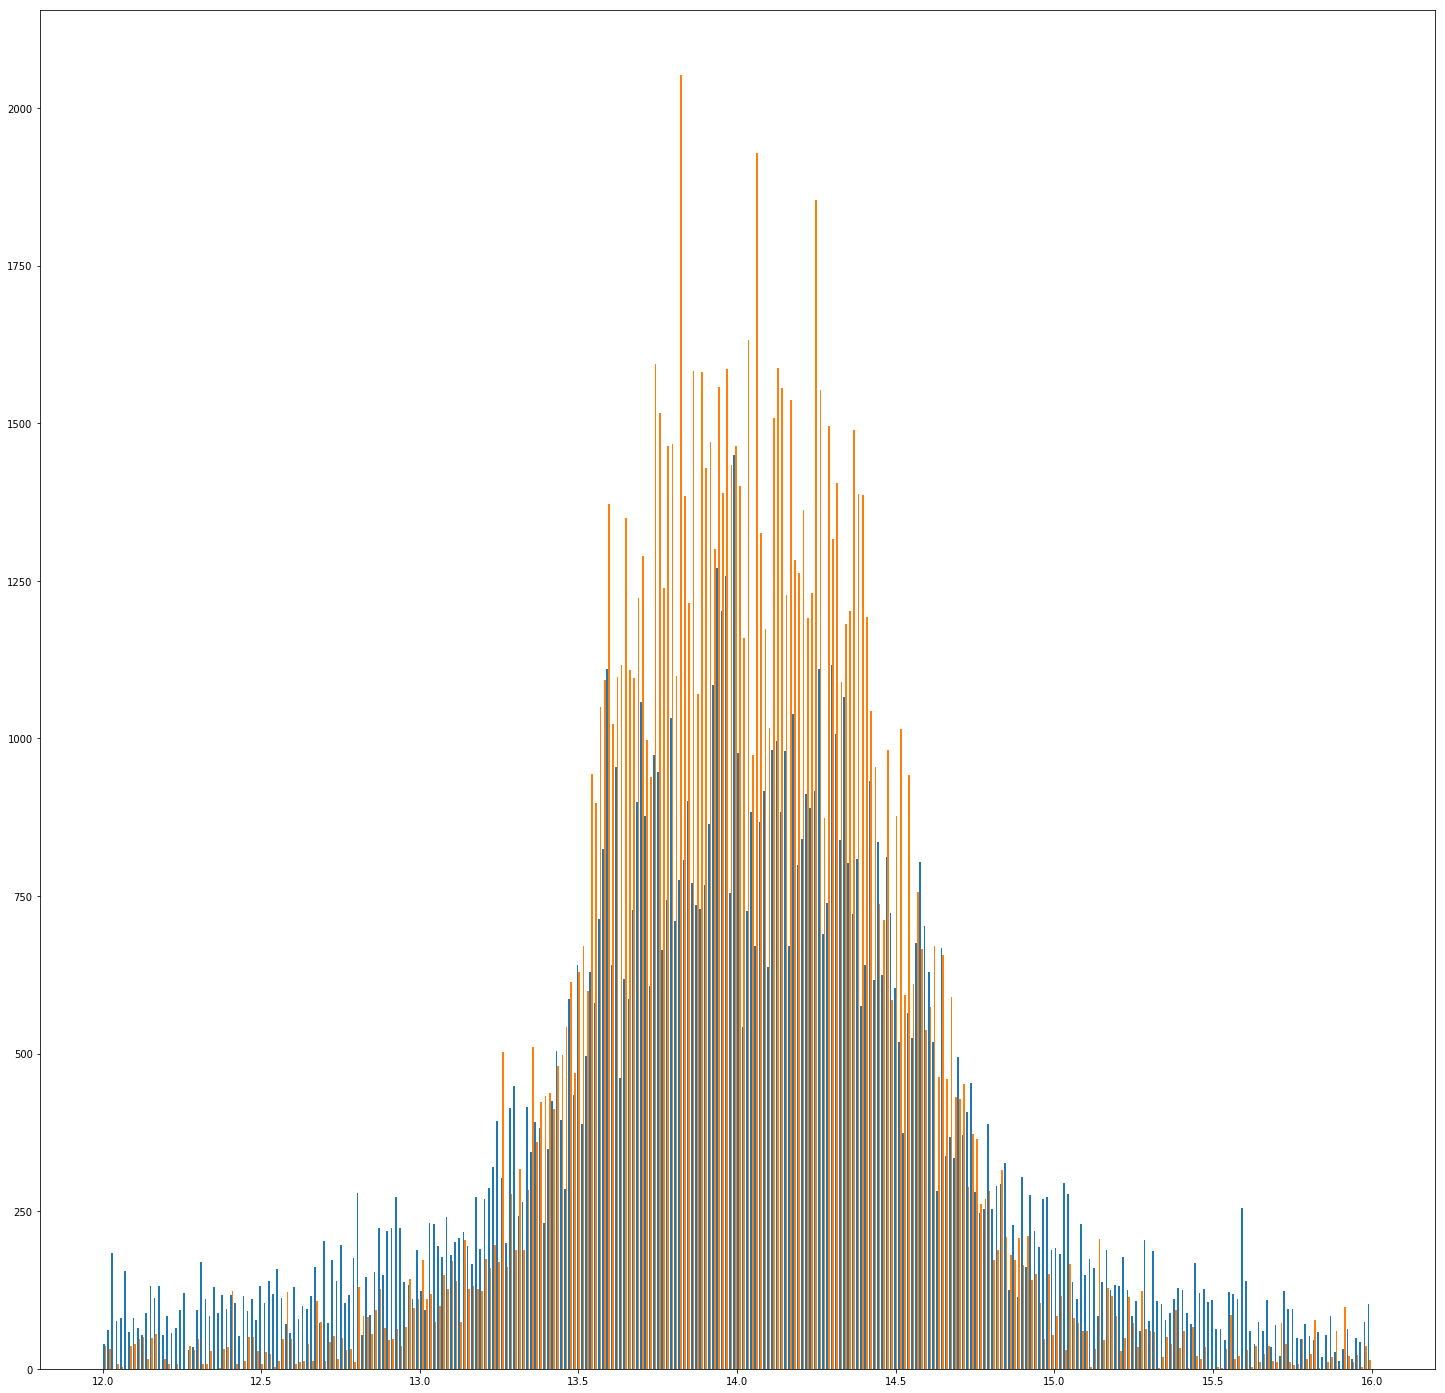

In [86]:
%%time
plt.figure(figsize=(25,25))
_,_,_ = plt.hist([feat_all_stacked['gamma']['center_x6'],feat_all_stacked['C100keV']['center_x6']], bins=300, range=(12,16))

C:\Artem\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


Wall time: 2.32 s


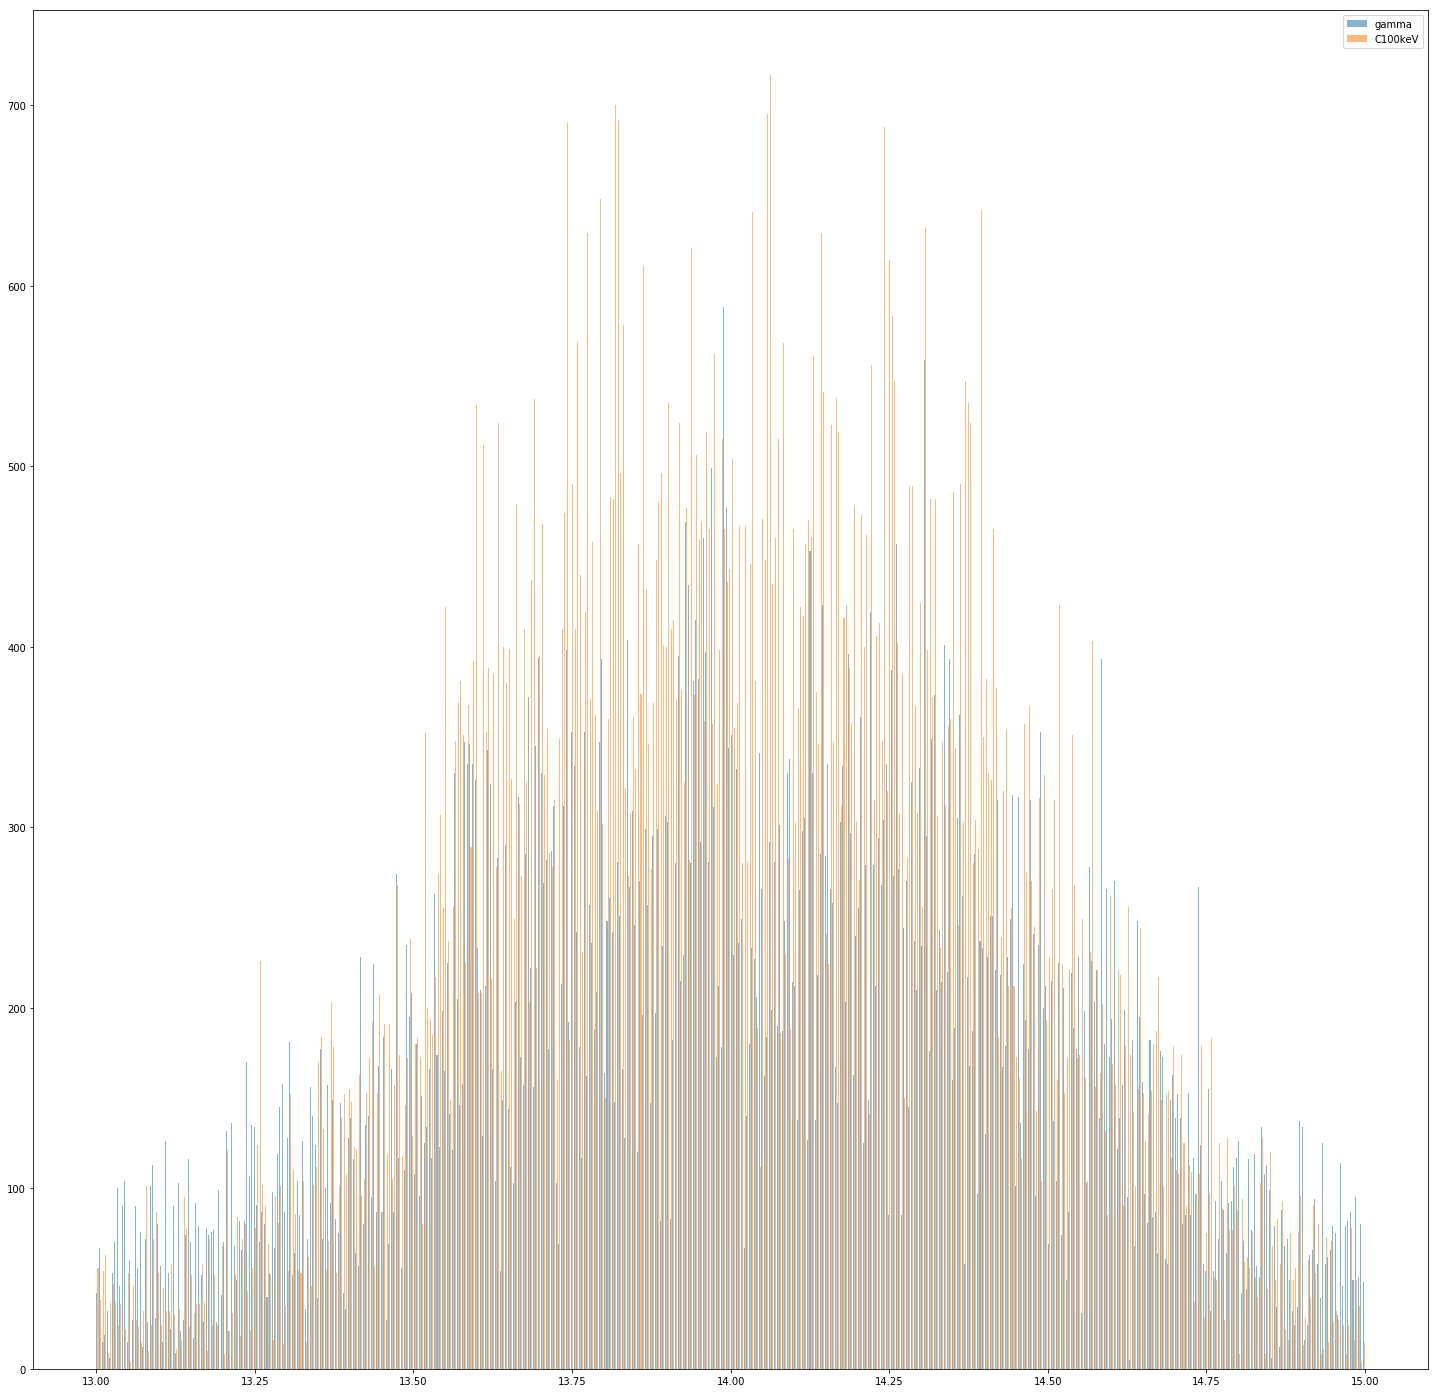

In [96]:
%%time
plt.figure(figsize=(25,25))
_,_,_ = plt.hist([feat_all_stacked['gamma']['center_x6'],feat_all_stacked['C100keV']['center_x6']], bins=500, range=(13,15), label=['gamma','C100keV'], alpha=0.55)
plt.legend()
plt.savefig('hist.pdf')

## 8. Smoothing distribution.

In [126]:
%%time
feat_names = feat_all_stacked['C100keV'].columns
features_raw = {}
for feat in feat_names:
    features_raw[feat] = pd.DataFrame(columns=[], index=[0])
    for name in ['gamma', 'C100keV']:
        conc_feat = pd.Series(feat_all_stacked[name][feat].values, name=name, index=range(feat_all_stacked[name].shape[0]))
        features_raw[feat] =  pd.concat([features_raw[feat], conc_feat], axis=1, ignore_index=False)

Wall time: 1.7 s


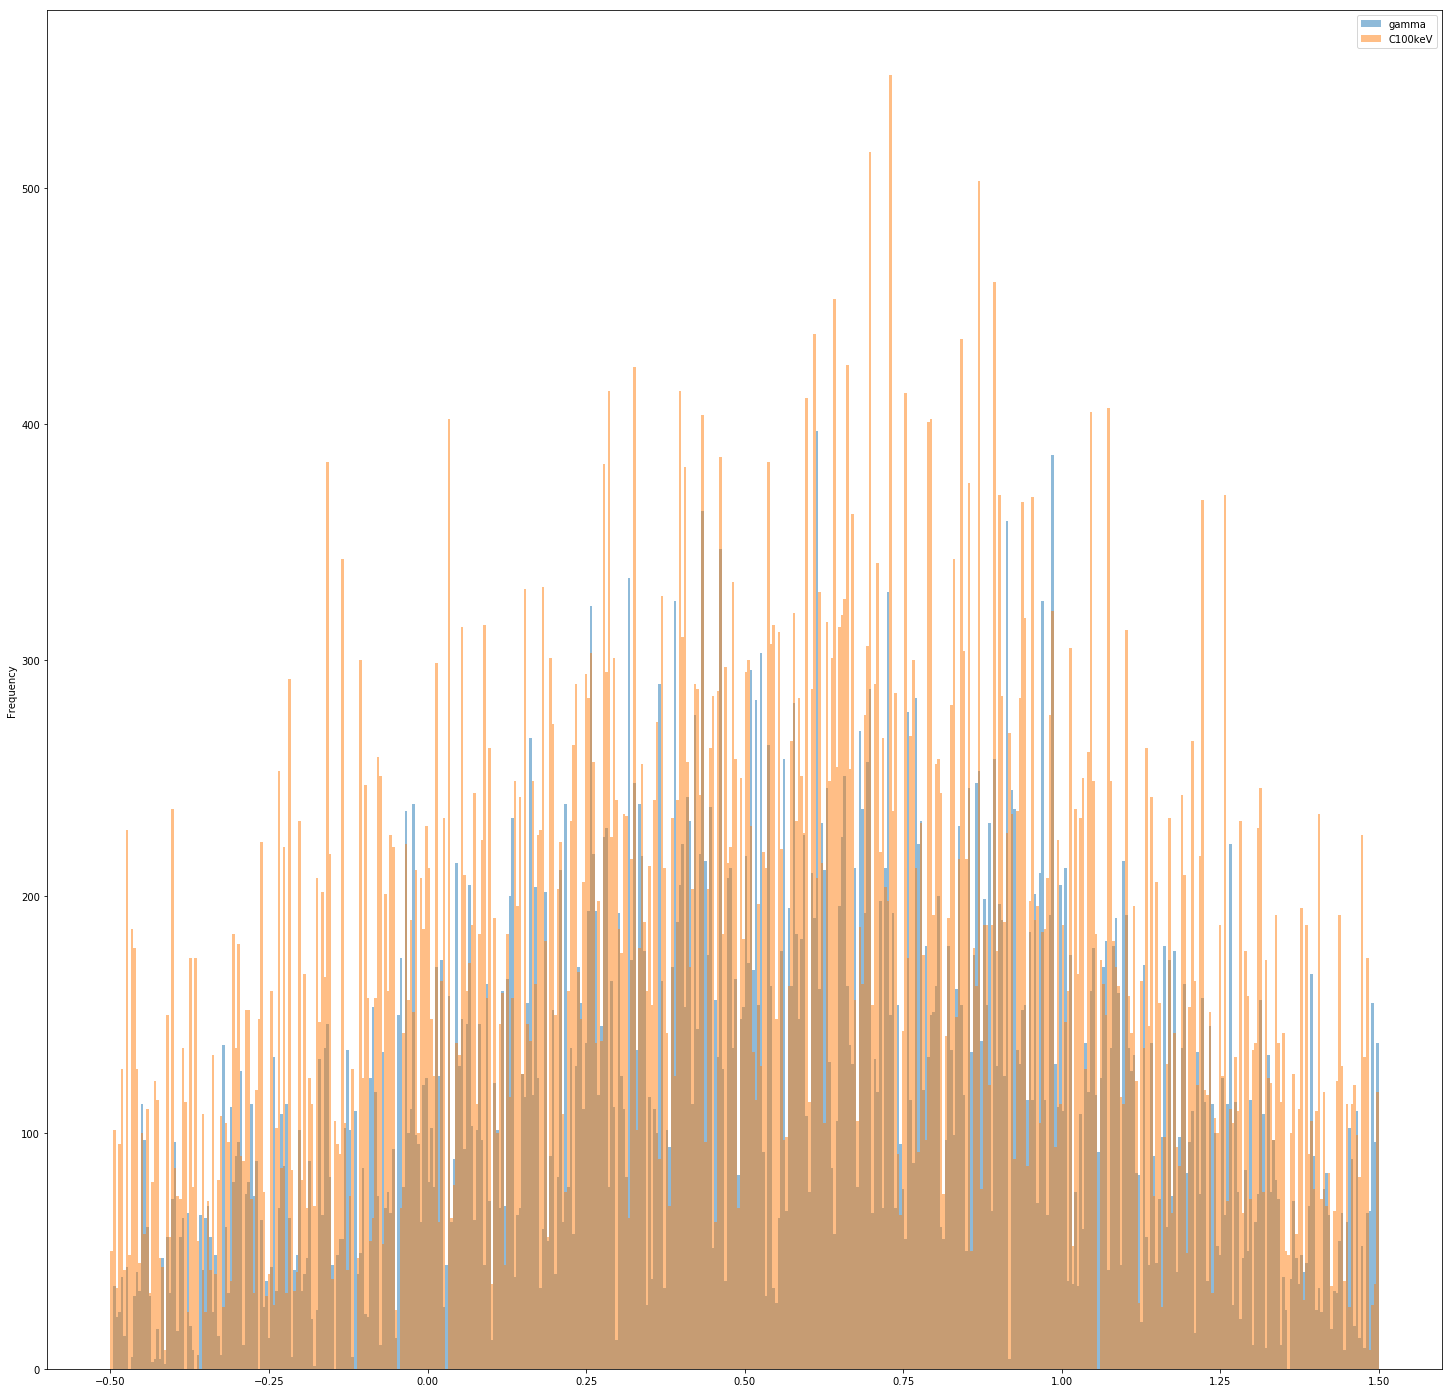

In [141]:
plt.figure()
features_raw['sig_xy6'].plot.hist(bins=500, figsize=(25,25), alpha=0.5, range=(-0.5,1.5))
plt.savefig('true_hist.pdf')

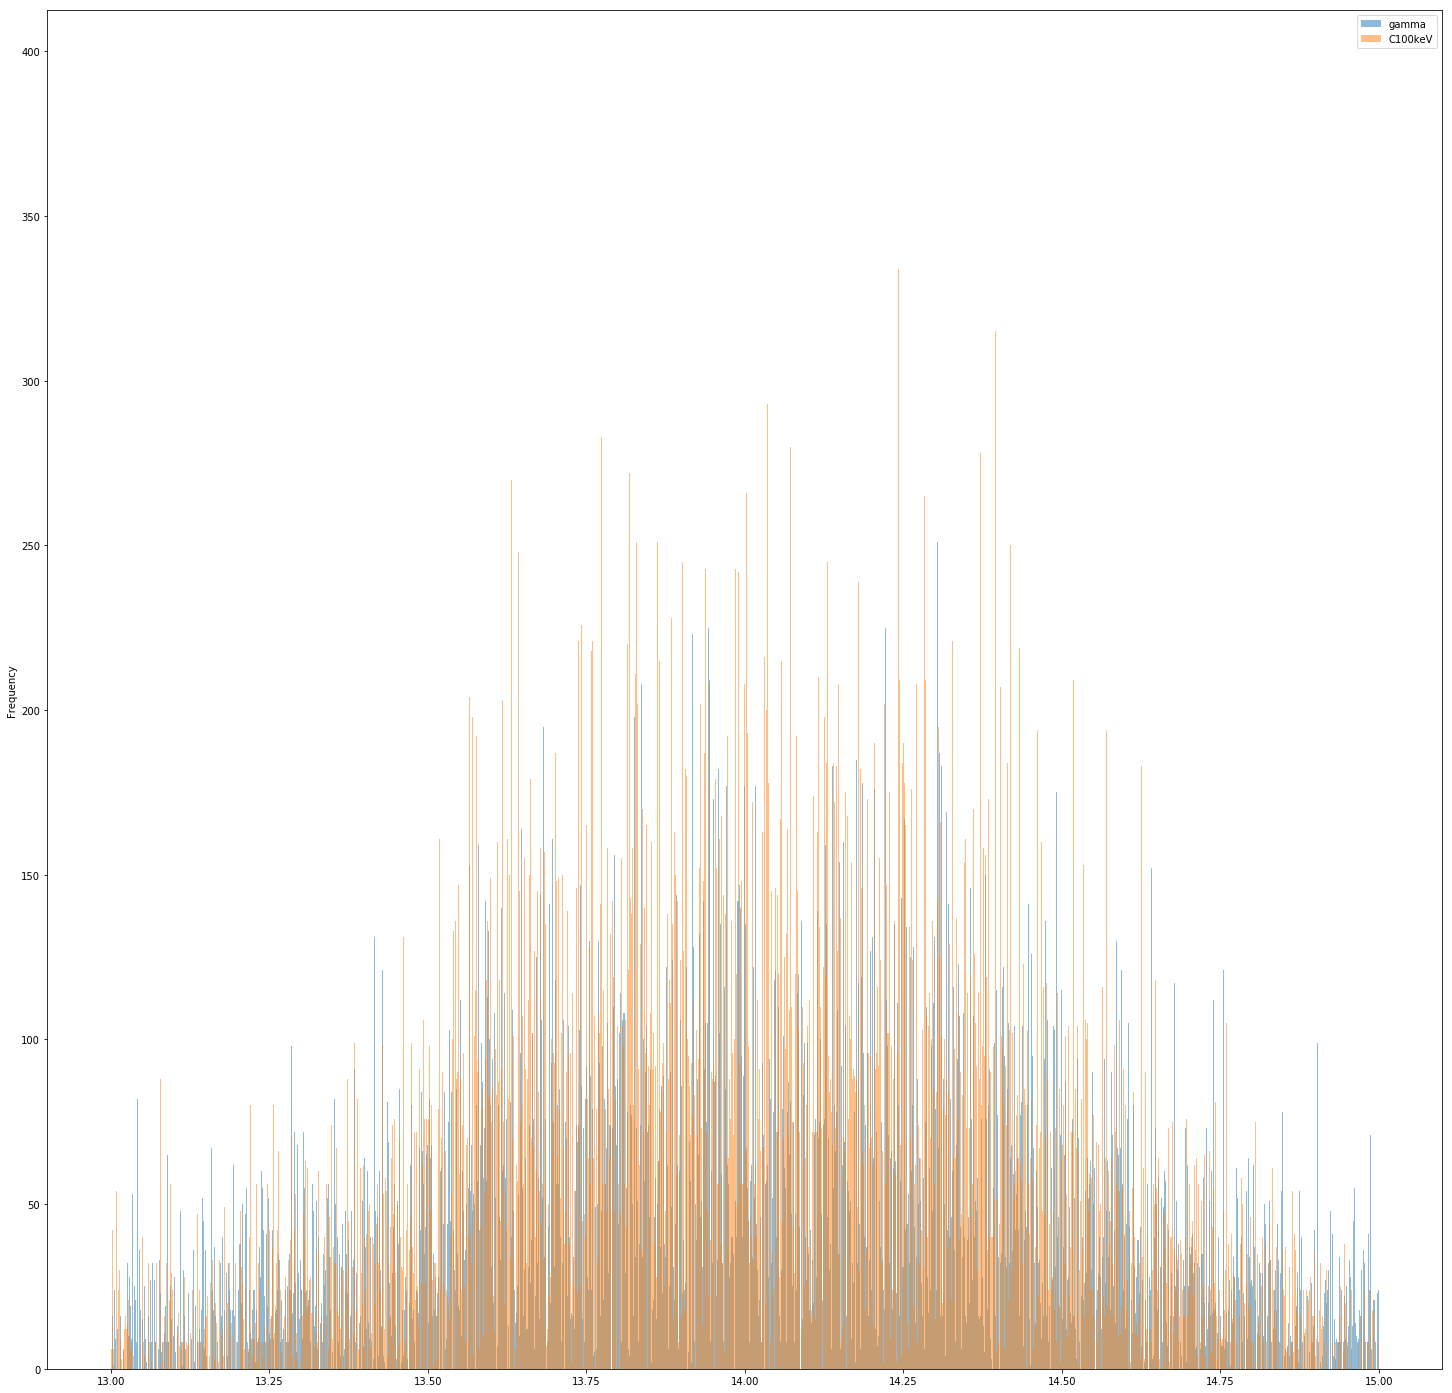

In [164]:
plt.figure()
features_raw['center_x6'].plot.hist(bins=2000, figsize=(25,25), alpha=0.5, range=(13,15))
#plt.savefig('true_hist.pdf')

In [100]:
%%time
X_stacked_unsh_train, X_stacked_unsh_test, y_stacked_unsh_train, y_stacked_unsh_test = feat_to_input_split(feat_all_stacked, class_names, test_size=0.1, shuffle=False)

Wall time: 2.25 s


In [119]:
%%time
randcla.set_params(n_estimators=100, n_jobs=-1)
randcla.fit(X_stacked_unsh_train.astype('float').round(decimals=0), y_stacked_unsh_train)
print ('precision ', precision_score(y_stacked_unsh_test, randcla.predict(X_stacked_unsh_test.astype('float').round(decimals=0))))

precision  1.0
Wall time: 17.7 s


train_shape  (399135, 20)  auc-roc:  1.0
train_shape  (399135, 16)  auc-roc:  1.0
train_shape  (399135, 12)  auc-roc:  1.0
train_shape  (399135, 10)  auc-roc:  1.0

 Index(['area1', 'center_x2', 'center_y5', 'min_ax5', 'sig_xy6', 'center_x7',
       'center_y7', 'area8', 'eps8'],
      dtype='object')
train_shape  (399135, 9)  auc-roc:  1.0

 Index(['center_x1', 'area1', 'min_ax1', 'center_x2', 'eps3', 'amplitude5',
       'center_x6', 'min_ax7'],
      dtype='object')
train_shape  (399135, 8)  auc-roc:  1.0

 Index(['sig_xy1', 'sig_xy3', 'area6', 'area7', 'min_ax7', 'amplitude8',
       'center_y8'],
      dtype='object')
train_shape  (399135, 7)  auc-roc:  1.0

 Index(['amplitude1', 'maj_ax1', 'center_y4', 'maj_ax4', 'area6', 'eps6'], dtype='object')
train_shape  (399135, 6)  auc-roc:  1.0

 Index(['min_ax1', 'maj_ax4', 'center_x6', 'area6', 'eps7'], dtype='object')
train_shape  (399135, 5)  auc-roc:  1.0

 Index(['center_y3', 'maj_ax5', 'area6', 'sig_xy7'], dtype='object')
train_sha

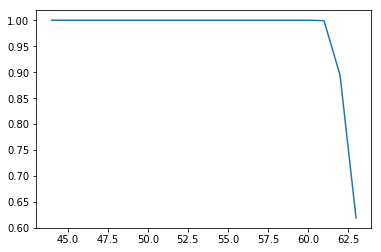

In [132]:
%%time
### NOT SHUFFLE DATA
randcla.set_params(n_estimators = 100, n_jobs = -1, oob_score=False)
n_drops = [44, 48, 52, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]
feat_giant_st_dropped = {}
auc_rocs = []
for n in n_drops:
    shuffle_cols = np.copy((feat_all_stacked['C100keV'].columns)[np.argsort(imp_feat_st_unsh)].values)
    np.random.shuffle(shuffle_cols)
    #print(shuffle_cols,'\n')
    for name in class_names:
        feat_giant_st_dropped[name] = feat_all_stacked[name].drop(shuffle_cols[-n:], axis=1)
    X_train, X_test, y_train, y_test = feat_to_input_split(feat_giant_st_dropped, class_names, test_size=0.25, shuffle=False)
    randcla.fit(X_train.astype('float').round(1), y_train)
    auc_rocs.append(roc_auc_score(y_test, (randcla.predict_proba(X_test.astype('float').round(1)))[:,1]))
    if feat_giant_st_dropped['C100keV'].shape[1]<10: print('\n',feat_giant_st_dropped['C100keV'].columns)
    print('train_shape ', X_train.shape, ' auc-roc: ', auc_rocs[-1])
plt.plot(n_drops, auc_rocs)

In [134]:
%%time
### NOT SHUFFLE DATA
randcla.set_params(n_estimators = 100, n_jobs = -1, oob_score=False)
n_drops = [62, 62, 62, 62, 62, 62, 62, 62, 62, 62]
feat_giant_st_dropped = {}
auc_rocs = []
for n in n_drops:
    shuffle_cols = np.copy((feat_all_stacked['C100keV'].columns)[np.argsort(imp_feat_st_unsh)].values)
    np.random.shuffle(shuffle_cols)
    #print(shuffle_cols,'\n')
    for name in class_names:
        feat_giant_st_dropped[name] = feat_all_stacked[name].drop(shuffle_cols[-n:], axis=1)
    X_train, X_test, y_train, y_test = feat_to_input_split(feat_giant_st_dropped, class_names, test_size=0.25, shuffle=False)
    randcla.fit(X_train.astype('float').round(1), y_train)
    auc_rocs.append(roc_auc_score(y_test, (randcla.predict_proba(X_test.astype('float').round(1)))[:,1]))
    if feat_giant_st_dropped['C100keV'].shape[1]<10: print('\n',feat_giant_st_dropped['C100keV'].columns)
    print('train_shape ', X_train.shape, ' auc-roc: ', auc_rocs[-1])
#plt.plot(n_drops, auc_rocs)


 Index(['sig_xy5', 'amplitude6'], dtype='object')
train_shape  (399135, 2)  auc-roc:  0.958779155494

 Index(['maj_ax7', 'center_y8'], dtype='object')
train_shape  (399135, 2)  auc-roc:  0.831706615788

 Index(['sig_xy1', 'area1'], dtype='object')
train_shape  (399135, 2)  auc-roc:  0.994519003719

 Index(['eps5', 'center_y8'], dtype='object')
train_shape  (399135, 2)  auc-roc:  0.692487304398

 Index(['eps5', 'min_ax6'], dtype='object')
train_shape  (399135, 2)  auc-roc:  0.767902616492

 Index(['area1', 'amplitude6'], dtype='object')
train_shape  (399135, 2)  auc-roc:  0.999765458812

 Index(['eps3', 'center_x6'], dtype='object')
train_shape  (399135, 2)  auc-roc:  0.688749061987

 Index(['center_x6', 'center_x8'], dtype='object')
train_shape  (399135, 2)  auc-roc:  0.676475475076

 Index(['amplitude2', 'amplitude4'], dtype='object')
train_shape  (399135, 2)  auc-roc:  0.967396152248

 Index(['center_x3', 'sig_xy8'], dtype='object')
train_shape  (399135, 2)  auc-roc:  0.792543660941

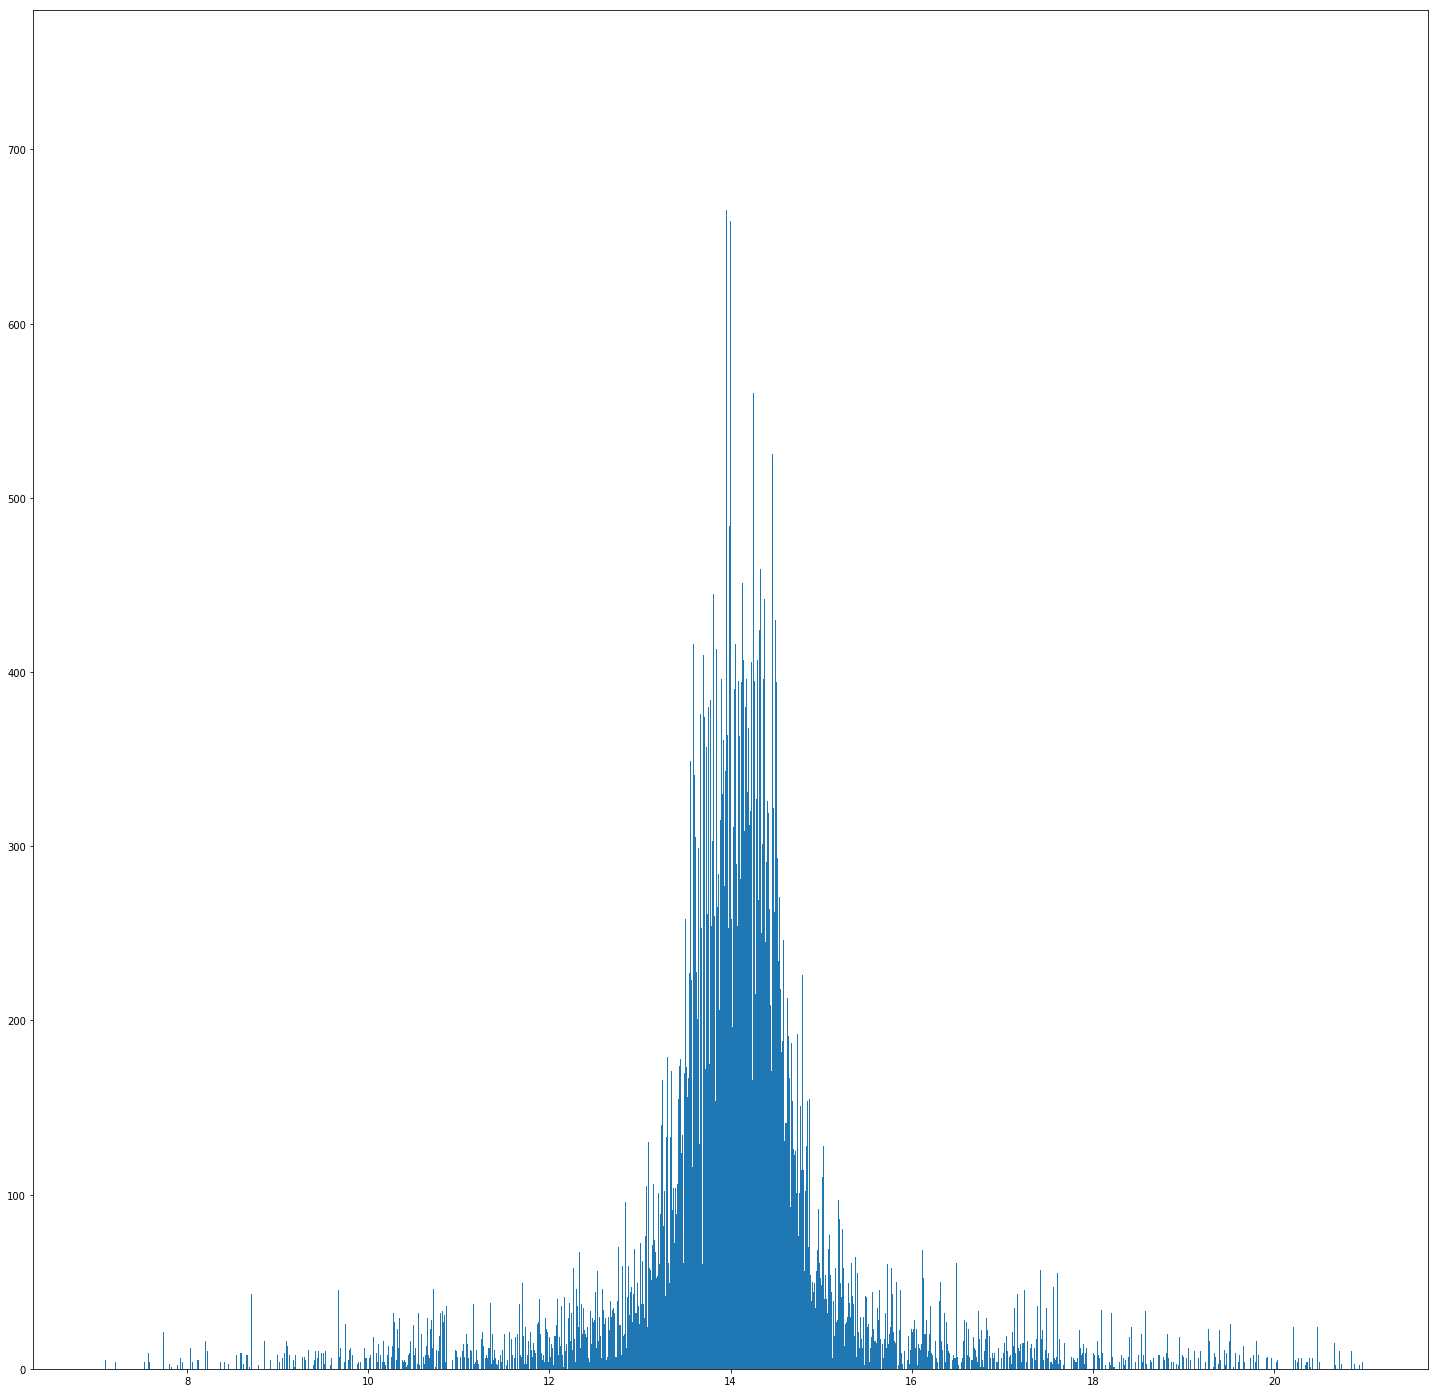

In [79]:
plt.figure(figsize=(25,25))
_ = plt.hist(X_train[:], bins=10000, range=(7,21))

In [84]:
feat_all_stacked['gamma']['center_x6'].shape

(124464,)

In [ ]:
## 7. Using the differences between polarization features instead of original features.

In [222]:
def feat_to_diff(feat, n_pol=8):
    """
    
    """
    ft_tmp = feat.columns.values[:n_pol]
    ft_names = []
    idx = feat.index
    for name in ft_tmp:
        ft_names.append(ft_tmp[:-1])
    
    for name in ft_names:
        tmp_feat = feat.drop(feat.columns, axis=1)
        for col in feat.columns:
            if col[:-1] is name:
                tmp_feat = pd.concat([tmp_feat, feat[col]], axis=1)
                feat = feat.drop([col], axis=1)
        feat = pd.concat([tmp_feat, feat], axis=1)
    
    ft_names=[]
    for name in ft_tmp:
        for i in np.arange(1, n_pol):
            ft_names.append(ft_tmp[:-1]+str(i))
    diff_ft = pd.DataFrame(np.diff(feat.values), columns=ft_names)
    
    return diff_ft 

In [223]:
feat_to_diff(feat_giant_stacked['C100keV']).head(1)

ValueError: Shape of passed values is (63, 17701), indices imply (7, 17701)

In [ ]:
np.diff()

In [212]:
import ROOT

ImportError: DLL load failed: %1 is not a valid Win32 application.

In [211]:
print(sys.path)

['', 'C:\\root\\bin', 'C:\\Artem\\Anaconda3\\python36.zip', 'C:\\Artem\\Anaconda3\\DLLs', 'C:\\Artem\\Anaconda3\\lib', 'C:\\Artem\\Anaconda3', 'C:\\Artem\\Anaconda3\\lib\\site-packages', 'C:\\Artem\\Anaconda3\\lib\\site-packages\\Babel-2.5.0-py3.6.egg', 'C:\\Artem\\Anaconda3\\lib\\site-packages\\Mako-1.0.7-py3.6.egg', 'C:\\Artem\\Anaconda3\\lib\\site-packages\\win32', 'C:\\Artem\\Anaconda3\\lib\\site-packages\\win32\\lib', 'C:\\Artem\\Anaconda3\\lib\\site-packages\\Pythonwin', 'C:\\Artem\\Anaconda3\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\scanner\\.ipython']


In [111]:
copa = giant_stacked_params['C100keV']
copa.get(['height1','sig_xy2']).head(1)

,height1,sig_xy2
0,27.763805,42.027276


In [55]:
feat_giant_data[class_names[0]].columns

Index([u'polar', u'amplitude', u'center_x', u'center_y', u'sig_xy', u'area',
       u'eps', u'minor_ax'],
      dtype='object')

In [57]:
copa = pd.DataFrame(giant_data_params['C100keV'][8:16].drop(['img_num','polar'],axis=1).values, index=giant_data_params['C100keV'][0:8].get('polar'), columns=giant_data_params['C100keV'].drop(['img_num','polar'],axis=1).columns)
popa = giant_data_params['C100keV'][8:16].get('img_num').values[0]
print (popa)
copa

2.0


,height,amplitude,center_x,center_y,sig_x,sig_y,sig_xy
polar,,,,,,,
1.0,25.391546,74.408202,14.409590,14.512226,5.404071,7.672402,0.463731
2.0,24.334133,59.645606,14.329225,14.533185,5.816713,7.875631,0.212840
3.0,23.411457,43.812067,14.374567,14.622436,6.872459,7.786300,0.029967
4.0,22.962829,40.218924,14.459931,14.381284,7.435987,7.190080,0.771465
5.0,23.170918,51.184038,14.415665,14.109579,6.711545,6.680334,1.437820
6.0,23.867563,69.552265,14.395915,14.036434,5.886534,6.656973,1.605094
7.0,24.712152,87.158119,14.413304,14.024474,5.364566,6.851709,1.447891
8.0,25.332947,94.885925,14.385614,14.038993,5.075495,7.051571,1.182264


In [84]:
jopa = pd.DataFrame(index=[popa])
for i in copa.index:
    nonopa = [iopa+str(int(i)) for iopa in copa.loc[i].index.values]
    print (nonopa)
    nopa = np.append(jopa.columns.values, [iopa+str(int(i)) for iopa in copa.loc[i].index.values])
    jopa = pd.DataFrame(np.append(jopa.values, copa.loc[i].values).reshape((1,-1)), columns=nopa, index=[popa])
jopa

['height1', 'amplitude1', 'center_x1', 'center_y1', 'sig_x1', 'sig_y1', 'sig_xy1']
['height2', 'amplitude2', 'center_x2', 'center_y2', 'sig_x2', 'sig_y2', 'sig_xy2']
['height3', 'amplitude3', 'center_x3', 'center_y3', 'sig_x3', 'sig_y3', 'sig_xy3']
['height4', 'amplitude4', 'center_x4', 'center_y4', 'sig_x4', 'sig_y4', 'sig_xy4']
['height5', 'amplitude5', 'center_x5', 'center_y5', 'sig_x5', 'sig_y5', 'sig_xy5']
['height6', 'amplitude6', 'center_x6', 'center_y6', 'sig_x6', 'sig_y6', 'sig_xy6']
['height7', 'amplitude7', 'center_x7', 'center_y7', 'sig_x7', 'sig_y7', 'sig_xy7']
['height8', 'amplitude8', 'center_x8', 'center_y8', 'sig_x8', 'sig_y8', 'sig_xy8']


,height1,amplitude1,center_x1,center_y1,sig_x1,sig_y1,sig_xy1,height2,amplitude2,center_x2,...,sig_x7,sig_y7,sig_xy7,height8,amplitude8,center_x8,center_y8,sig_x8,sig_y8,sig_xy8
2.0,25.391546,74.408202,14.40959,14.512226,5.404071,7.672402,0.463731,24.334133,59.645606,14.329225,...,5.364566,6.851709,1.447891,25.332947,94.885925,14.385614,14.038993,5.075495,7.051571,1.182264


In [85]:
copa2 = pd.DataFrame(giant_data_params['C100keV'][16:24].drop(['img_num','polar'],axis=1).values, index=giant_data_params['C100keV'][0:8].get('polar'), columns=giant_data_params['C100keV'].drop(['img_num','polar'],axis=1).columns)
popa2 = giant_data_params['C100keV'][16:24].get('img_num').values[0]
print (popa2)
copa2

3.0


,height,amplitude,center_x,center_y,sig_x,sig_y,sig_xy
polar,,,,,,,
1.0,29.016990,202.473188,14.385854,28.860082,181.625226,64.368335,63.250935
2.0,28.150002,193.093463,15.341466,29.623590,179.288465,70.205519,69.682300
3.0,26.575359,173.597672,16.182299,31.565013,186.966754,87.170490,78.841862
4.0,25.343270,165.480687,18.744609,35.355382,230.600249,127.183139,113.694306
5.0,24.531754,160.666713,19.298515,36.990574,275.335511,153.809152,136.748951
6.0,25.261131,147.165516,16.298500,33.159565,268.532100,118.681782,110.958290
7.0,26.574131,159.993785,14.602538,30.339340,237.000104,88.380695,84.656662
8.0,28.079039,182.245940,14.161763,29.111200,206.849392,72.375468,69.179624


In [86]:
jopa2 = pd.DataFrame(index=[popa2])
for i in copa2.index:
    nonopa = [iopa+str(int(i)) for iopa in copa2.loc[i].index.values]
    print (nonopa)
    nopa = np.append(jopa2.columns.values, [iopa+str(int(i)) for iopa in copa2.loc[i].index.values])
    jopa2 = pd.DataFrame(np.append(jopa2.values, copa2.loc[i].values).reshape((1,-1)), columns=nopa, index=[popa2])
jopa2

['height1', 'amplitude1', 'center_x1', 'center_y1', 'sig_x1', 'sig_y1', 'sig_xy1']
['height2', 'amplitude2', 'center_x2', 'center_y2', 'sig_x2', 'sig_y2', 'sig_xy2']
['height3', 'amplitude3', 'center_x3', 'center_y3', 'sig_x3', 'sig_y3', 'sig_xy3']
['height4', 'amplitude4', 'center_x4', 'center_y4', 'sig_x4', 'sig_y4', 'sig_xy4']
['height5', 'amplitude5', 'center_x5', 'center_y5', 'sig_x5', 'sig_y5', 'sig_xy5']
['height6', 'amplitude6', 'center_x6', 'center_y6', 'sig_x6', 'sig_y6', 'sig_xy6']
['height7', 'amplitude7', 'center_x7', 'center_y7', 'sig_x7', 'sig_y7', 'sig_xy7']
['height8', 'amplitude8', 'center_x8', 'center_y8', 'sig_x8', 'sig_y8', 'sig_xy8']


,height1,amplitude1,center_x1,center_y1,sig_x1,sig_y1,sig_xy1,height2,amplitude2,center_x2,...,sig_x7,sig_y7,sig_xy7,height8,amplitude8,center_x8,center_y8,sig_x8,sig_y8,sig_xy8
3.0,29.01699,202.473188,14.385854,28.860082,181.625226,64.368335,63.250935,28.150002,193.093463,15.341466,...,237.000104,88.380695,84.656662,28.079039,182.24594,14.161763,29.1112,206.849392,72.375468,69.179624


In [87]:
pd.concat([jopa, jopa2])

,height1,amplitude1,center_x1,center_y1,sig_x1,sig_y1,sig_xy1,height2,amplitude2,center_x2,...,sig_x7,sig_y7,sig_xy7,height8,amplitude8,center_x8,center_y8,sig_x8,sig_y8,sig_xy8
2.0,25.391546,74.408202,14.409590,14.512226,5.404071,7.672402,0.463731,24.334133,59.645606,14.329225,...,5.364566,6.851709,1.447891,25.332947,94.885925,14.385614,14.038993,5.075495,7.051571,1.182264
3.0,29.016990,202.473188,14.385854,28.860082,181.625226,64.368335,63.250935,28.150002,193.093463,15.341466,...,237.000104,88.380695,84.656662,28.079039,182.245940,14.161763,29.111200,206.849392,72.375468,69.179624


In [91]:
range(1,9)

[1, 2, 3, 4, 5, 6, 7, 8]

In [92]:
cocopa = pd.DataFrame()
pd.concat([cocopa, jopa, jopa2])

,height1,amplitude1,center_x1,center_y1,sig_x1,sig_y1,sig_xy1,height2,amplitude2,center_x2,...,sig_x7,sig_y7,sig_xy7,height8,amplitude8,center_x8,center_y8,sig_x8,sig_y8,sig_xy8
2.0,25.391546,74.408202,14.409590,14.512226,5.404071,7.672402,0.463731,24.334133,59.645606,14.329225,...,5.364566,6.851709,1.447891,25.332947,94.885925,14.385614,14.038993,5.075495,7.051571,1.182264
3.0,29.016990,202.473188,14.385854,28.860082,181.625226,64.368335,63.250935,28.150002,193.093463,15.341466,...,237.000104,88.380695,84.656662,28.079039,182.245940,14.161763,29.111200,206.849392,72.375468,69.179624
